In [6]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
import seaborn as sns

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics
import warnings

RANDOM_STATE = 41825352

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [3]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобработаем тексты пресс-релизов.

In [51]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


# инициализируем tf-idf векторизатор с нашим препроцессингом
vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
    max_df=0.5, min_df=8
)

# обучаем векторизатор на текстах релизов
tf_idf = vectorizer.fit_transform(X.release).toarray()

Подберем параметры для алгоритмов `KNeighborsClassifier` и `TfidfVectorizer`.

In [52]:
param_grid = ParameterGrid({
    'n_neighbors': np.arange(1, 10),
    'weights': ['uniform', 'distance'],
    'p': np.arange(1, 2, 0.05),
    'algorithm': ['brute'],
})

auc = []
for param in tqdm(param_grid):
    result = calc_metrics(tf_idf, y, KNeighborsClassifier, name=" ", plot=False, calc_jobs=-1, **param)
    auc.append(result)

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 360/360 [00:20<00:00, 17.87it/s]

Лучшая модель - KNeighborsClassifier(algorithm='brute', n_neighbors=2, p=1.8000000000000007,
                     weights='distance')
ROC-AUC = 0.816075514874142


              precision    recall  f1-score   support

        -1.0       0.71      0.74      0.72        23
         0.0       0.59      0.62      0.60        26
         1.0       0.82      0.74      0.78        19

    accuracy                           0.69        68
   macro avg       0.71      0.70      0.70        68
weighted avg       0.70      0.69      0.69        68



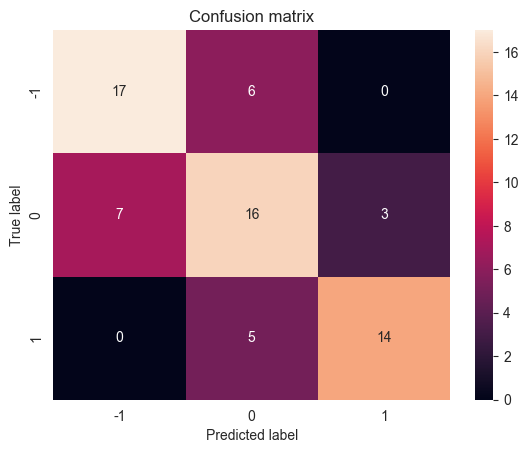

In [53]:
metric, model = calc_metrics(
    tf_idf,
    y,
    KNeighborsClassifier,
    name="K-neighbors tf_idf",
    **best_model.get_params()
)

In [54]:
metric

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.691176,0.701652,0.697119,0.708152,0.812255,0.816076
